# Challenge Question

Use a pretrained ResNet 18 and train on the STL10 dataset. Use image transforms without using discriminative learning or 1 cycle scheduling and measure its effect on your model's performance.

## 1. Download the data 

Download the stl10 data at https://cs.stanford.edu/~acoates/stl10/.  

#### Data overview

10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck. <br>
Images are 96x96 pixels, color. <br>
500 training images (10 pre-defined folds), 800 test images per class. <br>
100000 unlabeled images for unsupervised learning. <br>

##### We will be using train and test set.  

## 2. Create folders of train and val.  

In [1]:
from __future__ import print_function, division

import scipy.io
import numpy as np
from PIL import Image

import os
import os.path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import copy
import random
import pandas as pd

cudnn.benchmark = True
plt.ion()

In [2]:
train_mat = scipy.io.loadmat('stl10_matlab/train.mat') 
test_mat = scipy.io.loadmat('stl10_matlab/test.mat') 

Each data is 1 X 27648 matrix.  It is important to change the dimension to (-1, 3, 96, 96), and transpose them so we can view the image.  

In [3]:
Xtrain = train_mat['X']
ytrain = train_mat['y']
Xtrain = np.reshape(Xtrain, (-1, 3, 96, 96))
Xtrain = np.transpose(Xtrain, (0, 3, 2, 1))

Xtest = test_mat['X']
ytest = test_mat['y']
Xtest = np.reshape(Xtest, (-1, 3, 96, 96))
Xtest = np.transpose(Xtest, (0, 3, 2, 1))

class_names = train_mat['class_names']

In [4]:
print("We have %d train data and %d test data" % (len(Xtrain), len(Xtest)))

We have 5000 train data and 8000 test data


#### We will use only 200 train data and 100 test data.  The code keeps crushing with more data set.  <br>

The goal is to know which image transforms give the best model's performance.  As long as we keep the same data set, although it is a relatively small size, the results will be somewhat meaningful.   

In [5]:
Ntrain = 200
Ntest = 100

#### Create folders of train and val.  

Each train and val folders consist of 10 subfolders of each class.  

In [6]:
current_directory = os.getcwd()
print(current_directory)

/Users/jasonpark/Desktop/Fellowship_ai


In [7]:
stl10_folder = current_directory + '/stl10_folder'
if not os.path.exists(stl10_folder):
    os.makedirs(stl10_folder)

In [8]:
stl10_train_folder = current_directory + '/stl10_folder/train'
if not os.path.exists(stl10_train_folder):
    os.makedirs(stl10_train_folder)

In [9]:
for folder_names in class_names[0]:
    #print(folder_names[0])
    folder = stl10_train_folder + '/' + folder_names[0]
    if not os.path.exists(folder):
        os.makedirs(folder)

In [10]:
for k in range(Ntrain):
#for k in range(len(Xtrain)):

    for folder_names in class_names[0]:
        if class_names[0][ytrain[k][0] - 1][0] == folder_names[0]:
            im = Image.fromarray(Xtrain[k])
            name = 'stl10_folder/train/' + folder_names[0] +'/' + folder_names[0] + str(k) + '.jpg'
            if os.path.exists(name):
                pass
            else:
                im.save(name)

In [11]:
stl10_val_folder = current_directory + '/stl10_folder/val'
if not os.path.exists(stl10_val_folder):
    os.makedirs(stl10_val_folder)

In [12]:
for folder_names in class_names[0]:
    #print(folder_names[0])
    folder = stl10_val_folder + '/' + folder_names[0]
    if not os.path.exists(folder):
        os.makedirs(folder)

In [13]:
for k in range(Ntest):
#for k in range(len(Xtest)):

    for folder_names in class_names[0]:
        if class_names[0][ytest[k][0] - 1][0] == folder_names[0]:
            im = Image.fromarray(Xtest[k])
            name = 'stl10_folder/val/' + folder_names[0] +'/' + folder_names[0] + str(k) + '.jpg'
            if os.path.exists(name):
                pass
            else:
                im.save(name)

#### The number of epochs is 5.  With the epochs' number more than 5, the code crushes again.  

In [14]:
N_epoch = 5

In [15]:
def show_some_Xtrain_image():
    
    random_numbers = random.sample(range(0, len(Xtrain)), 3)
    
    print("Here are some images from train set and their labels")
    print('-' * 30)
    for i in random_numbers:
        plt.title("This is a " + class_names[0][ytrain[i][0] - 1][0])
        plt.imshow(Xtrain[i], interpolation='nearest')
        plt.show()
        
        print('-' * 30)

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=N_epoch):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss_list = []
    train_acc_list = []
    
    val_loss_list = []
    val_acc_list = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            if phase == 'val':
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)
            
             
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_acc

Let's view some image and its class in train set. 

Here are some images from train set and their labels
------------------------------


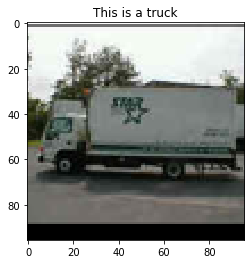

------------------------------


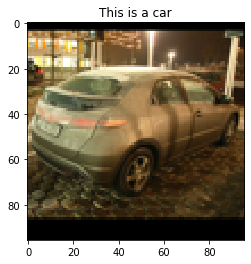

------------------------------


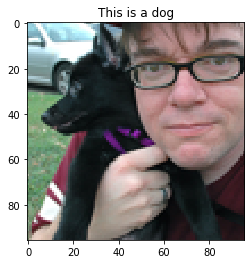

------------------------------


In [17]:
show_some_Xtrain_image()

## 3. Create model and train


#### Image Transforms. 

We will test 10 image transforms, and they are:

Resize, CenterCrop <br>
Resize, CenterCrop, RandomPerspective <br>
Resize, CenterCrop, ColorJitter<br>
Resize, RandomCrop<br>
Resize, CenterCrop, RandomGrayscale<br>
Resize, CenterCrop, RandomHorizontalFlip<br>
RandomResizedCrop<br>
RandomRotation<br>
Resize, CenterCrop, RandomVerticalFlip<br>
Resize, CenterCrop, RandomAffine<br>

In [18]:
data_dir = 'stl10_folder'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

basic_train_transforms = [
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

val_transfrom_list = [
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

additional_train_transforms_list = [[transforms.Resize(256),transforms.CenterCrop(224)],
                                    [transforms.Resize(256),transforms.CenterCrop(224),transforms.RandomPerspective(distortion_scale=0.6, p=1.0)],
                                    [transforms.Resize(256),transforms.CenterCrop(224),transforms.ColorJitter(brightness=.5, hue=.3)],
                                    [transforms.Resize(256),transforms.RandomCrop(224)],
                                    [transforms.Resize(256),transforms.CenterCrop(224),transforms.RandomGrayscale(p=0.1)],
                                    [transforms.Resize(256),transforms.CenterCrop(224),transforms.RandomHorizontalFlip(p=0.5)],
                                    [transforms.RandomResizedCrop(256)],
                                    [transforms.RandomRotation(0,360)],
                                    [transforms.Resize(256),transforms.CenterCrop(224),transforms.RandomVerticalFlip(p=0.5)],
                                    [transforms.Resize(256),transforms.CenterCrop(224),transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))]
                                   ]
transforms_description = ['Resize, CenterCrop', 
                         'Resize, CenterCrop, RandomPerspective',
                        'Resize, CenterCrop, ColorJitter',
                         'Resize, RandomCrop',
                         'Resize, CenterCrop, RandomGrayscale',
                         'Resize, CenterCrop, RandomHorizontalFlip',
                         'RandomResizedCrop',
                         'RandomRotation',
                         'Resize, CenterCrop, RandomVerticalFlip',
                         'Resize, CenterCrop, RandomAffine'
                         ]

In [19]:
list_of_train_loss_list = []
list_of_train_acc_list = []
list_of_val_loss_list = []
list_of_val_acc_list = []
list_of_best_acc = []

### Resnet18

We choose resnet18 as the model, with pretrained weights.  

We change the num of features to 10 since there are 10 classes.  

And set param.requires_grad = False so that weights stay fixed. Only changing weights will be at the final layer.  

In [20]:
k = 0

additional_train_transforms = additional_train_transforms_list[k]


data_transforms = {
'train': transforms.Compose(additional_train_transforms + basic_train_transforms),
'val': transforms.Compose(val_transfrom_list),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print('Training with transforms of ' + transforms_description[k])
print('')

model_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_acc = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = N_epoch)


list_of_train_loss_list.append(train_loss_list)
list_of_train_acc_list.append(train_acc_list)
list_of_val_loss_list.append(val_loss_list)
list_of_val_acc_list.append(val_acc_list)
list_of_best_acc.append(best_acc)

Training with transforms of Resize, CenterCrop

Epoch 0/4
----------
train Loss: 1.9969 Acc: 0.2950
val Loss: 1.1705 Acc: 0.5800

Epoch 1/4
----------
train Loss: 1.3055 Acc: 0.5750
val Loss: 0.7702 Acc: 0.7400

Epoch 2/4
----------
train Loss: 1.0313 Acc: 0.6650
val Loss: 0.6360 Acc: 0.8000

Epoch 3/4
----------
train Loss: 0.8519 Acc: 0.7325
val Loss: 0.6595 Acc: 0.7800

Epoch 4/4
----------
train Loss: 0.7754 Acc: 0.7550
val Loss: 0.6498 Acc: 0.7100

Training complete in 4m 30s
Best val Acc: 0.800000


In [21]:
x_list = np.arange(0., N_epoch, 1)

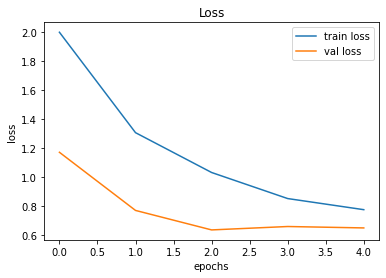

In [22]:
plt.plot(x_list, train_loss_list, label='train loss')
plt.plot(x_list, val_loss_list, label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

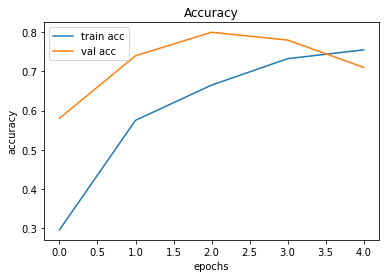

In [23]:
plt.plot(x_list, train_acc_list, label='train acc')
plt.plot(x_list, val_acc_list, label='val acc')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#### The first result

The first image transforms were Resize and CenterCrop.  The best val accuracy was 0.8.  

##### Note :  I had made a forloop with range 10, but code crashed again for some unkown reason.  So I switched back so I can train each image transforms session one by one.

The rest of parts is the training of different image transforms combinations.  

In [24]:
k = 1

additional_train_transforms = additional_train_transforms_list[k]


data_transforms = {
'train': transforms.Compose(additional_train_transforms + basic_train_transforms),
'val': transforms.Compose(val_transfrom_list),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print('Training with transforms of ' + transforms_description[k])
print('')

model_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_acc = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = N_epoch)


list_of_train_loss_list.append(train_loss_list)
list_of_train_acc_list.append(train_acc_list)
list_of_val_loss_list.append(val_loss_list)
list_of_val_acc_list.append(val_acc_list)
list_of_best_acc.append(best_acc)

Training with transforms of Resize, CenterCrop, RandomPerspective

Epoch 0/4
----------
train Loss: 2.2431 Acc: 0.2200
val Loss: 1.9306 Acc: 0.2400

Epoch 1/4
----------
train Loss: 1.6839 Acc: 0.4175
val Loss: 1.8048 Acc: 0.3600

Epoch 2/4
----------
train Loss: 1.5438 Acc: 0.4475
val Loss: 1.3242 Acc: 0.5300

Epoch 3/4
----------
train Loss: 1.3891 Acc: 0.5025
val Loss: 1.2713 Acc: 0.5400

Epoch 4/4
----------
train Loss: 1.3528 Acc: 0.5350
val Loss: 1.0528 Acc: 0.6000

Training complete in 4m 28s
Best val Acc: 0.600000


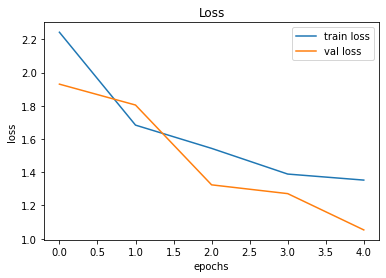

In [25]:
plt.plot(x_list, train_loss_list, label='train loss')
plt.plot(x_list, val_loss_list, label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

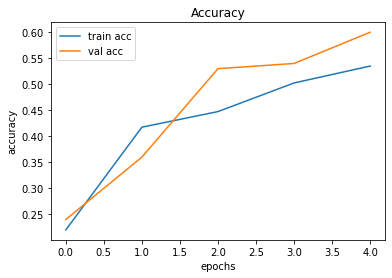

In [26]:
plt.plot(x_list, train_acc_list, label='train acc')
plt.plot(x_list, val_acc_list, label='val acc')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [27]:
k = 2

additional_train_transforms = additional_train_transforms_list[k]


data_transforms = {
'train': transforms.Compose(additional_train_transforms + basic_train_transforms),
'val': transforms.Compose(val_transfrom_list),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print('Training with transforms of ' + transforms_description[k])
print('')

model_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_acc = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = N_epoch)


list_of_train_loss_list.append(train_loss_list)
list_of_train_acc_list.append(train_acc_list)
list_of_val_loss_list.append(val_loss_list)
list_of_val_acc_list.append(val_acc_list)
list_of_best_acc.append(best_acc)

Training with transforms of Resize, CenterCrop, ColorJitter

Epoch 0/4
----------
train Loss: 2.0933 Acc: 0.2550
val Loss: 1.2759 Acc: 0.6100

Epoch 1/4
----------
train Loss: 1.4488 Acc: 0.5300
val Loss: 0.9118 Acc: 0.7400

Epoch 2/4
----------
train Loss: 1.2307 Acc: 0.5950
val Loss: 0.8247 Acc: 0.6900

Epoch 3/4
----------
train Loss: 1.1090 Acc: 0.5850
val Loss: 0.8438 Acc: 0.7100

Epoch 4/4
----------
train Loss: 0.9387 Acc: 0.6950
val Loss: 0.6936 Acc: 0.7900

Training complete in 4m 34s
Best val Acc: 0.790000


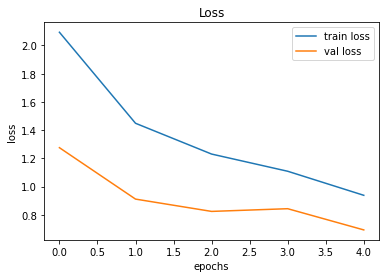

In [28]:
plt.plot(x_list, train_loss_list, label='train loss')
plt.plot(x_list, val_loss_list, label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

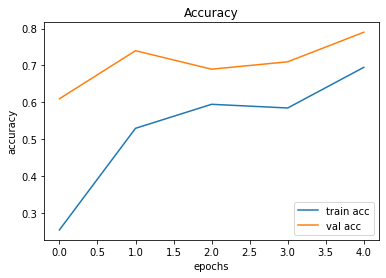

In [29]:
plt.plot(x_list, train_acc_list, label='train acc')
plt.plot(x_list, val_acc_list, label='val acc')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [30]:
k = 3

additional_train_transforms = additional_train_transforms_list[k]


data_transforms = {
'train': transforms.Compose(additional_train_transforms + basic_train_transforms),
'val': transforms.Compose(val_transfrom_list),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print('Training with transforms of ' + transforms_description[k])
print('')

model_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_acc = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = N_epoch)


list_of_train_loss_list.append(train_loss_list)
list_of_train_acc_list.append(train_acc_list)
list_of_val_loss_list.append(val_loss_list)
list_of_val_acc_list.append(val_acc_list)
list_of_best_acc.append(best_acc)

Training with transforms of Resize, RandomCrop

Epoch 0/4
----------
train Loss: 1.9668 Acc: 0.3300
val Loss: 1.4129 Acc: 0.5500

Epoch 1/4
----------
train Loss: 1.4108 Acc: 0.5225
val Loss: 0.7595 Acc: 0.7800

Epoch 2/4
----------
train Loss: 0.9903 Acc: 0.6850
val Loss: 0.7990 Acc: 0.7400

Epoch 3/4
----------
train Loss: 0.8638 Acc: 0.6975
val Loss: 0.6913 Acc: 0.7400

Epoch 4/4
----------
train Loss: 0.8041 Acc: 0.7500
val Loss: 0.6964 Acc: 0.7500

Training complete in 4m 35s
Best val Acc: 0.780000


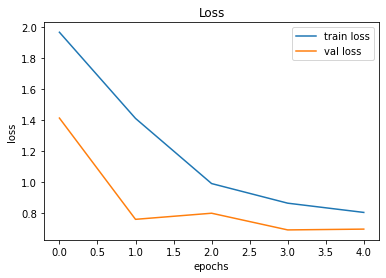

In [31]:
plt.plot(x_list, train_loss_list, label='train loss')
plt.plot(x_list, val_loss_list, label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

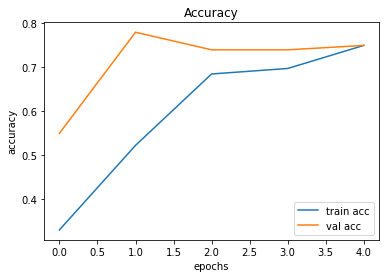

In [32]:
plt.plot(x_list, train_acc_list, label='train acc')
plt.plot(x_list, val_acc_list, label='val acc')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [33]:
k = 4

additional_train_transforms = additional_train_transforms_list[k]


data_transforms = {
'train': transforms.Compose(additional_train_transforms + basic_train_transforms),
'val': transforms.Compose(val_transfrom_list),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print('Training with transforms of ' + transforms_description[k])
print('')

model_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_acc = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = N_epoch)


list_of_train_loss_list.append(train_loss_list)
list_of_train_acc_list.append(train_acc_list)
list_of_val_loss_list.append(val_loss_list)
list_of_val_acc_list.append(val_acc_list)
list_of_best_acc.append(best_acc)

Training with transforms of Resize, CenterCrop, RandomGrayscale

Epoch 0/4
----------
train Loss: 1.9913 Acc: 0.3025
val Loss: 1.2757 Acc: 0.5400

Epoch 1/4
----------
train Loss: 1.3747 Acc: 0.5225
val Loss: 0.9166 Acc: 0.6900

Epoch 2/4
----------
train Loss: 1.0872 Acc: 0.6675
val Loss: 0.8037 Acc: 0.7000

Epoch 3/4
----------
train Loss: 0.9249 Acc: 0.7075
val Loss: 0.6887 Acc: 0.7300

Epoch 4/4
----------
train Loss: 0.8157 Acc: 0.7625
val Loss: 0.6265 Acc: 0.7700

Training complete in 4m 36s
Best val Acc: 0.770000


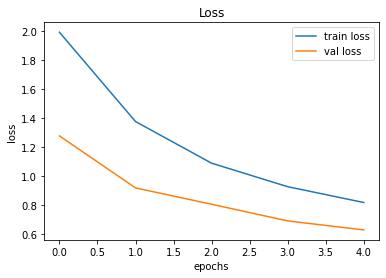

In [34]:
plt.plot(x_list, train_loss_list, label='train loss')
plt.plot(x_list, val_loss_list, label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

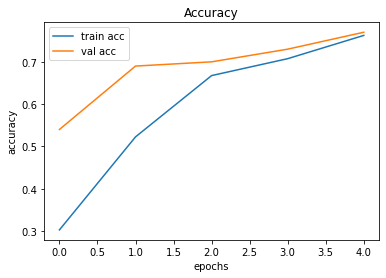

In [35]:
plt.plot(x_list, train_acc_list, label='train acc')
plt.plot(x_list, val_acc_list, label='val acc')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [36]:
k = 5

additional_train_transforms = additional_train_transforms_list[k]


data_transforms = {
'train': transforms.Compose(additional_train_transforms + basic_train_transforms),
'val': transforms.Compose(val_transfrom_list),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print('Training with transforms of ' + transforms_description[k])
print('')

model_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_acc = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = N_epoch)


list_of_train_loss_list.append(train_loss_list)
list_of_train_acc_list.append(train_acc_list)
list_of_val_loss_list.append(val_loss_list)
list_of_val_acc_list.append(val_acc_list)
list_of_best_acc.append(best_acc)

Training with transforms of Resize, CenterCrop, RandomHorizontalFlip

Epoch 0/4
----------
train Loss: 2.0303 Acc: 0.2900
val Loss: 1.1625 Acc: 0.5900

Epoch 1/4
----------
train Loss: 1.3041 Acc: 0.5825
val Loss: 0.8200 Acc: 0.7500

Epoch 2/4
----------
train Loss: 0.9812 Acc: 0.6975
val Loss: 0.6609 Acc: 0.7900

Epoch 3/4
----------
train Loss: 0.9024 Acc: 0.7100
val Loss: 0.6465 Acc: 0.7700

Epoch 4/4
----------
train Loss: 0.7960 Acc: 0.7375
val Loss: 0.7030 Acc: 0.7500

Training complete in 4m 47s
Best val Acc: 0.790000


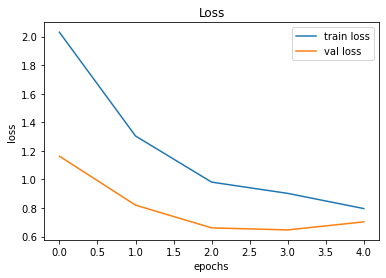

In [37]:
plt.plot(x_list, train_loss_list, label='train loss')
plt.plot(x_list, val_loss_list, label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

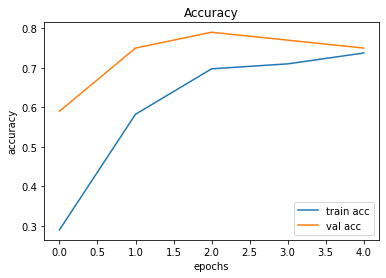

In [38]:
plt.plot(x_list, train_acc_list, label='train acc')
plt.plot(x_list, val_acc_list, label='val acc')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [39]:
k = 6

additional_train_transforms = additional_train_transforms_list[k]


data_transforms = {
'train': transforms.Compose(additional_train_transforms + basic_train_transforms),
'val': transforms.Compose(val_transfrom_list),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print('Training with transforms of ' + transforms_description[k])
print('')

model_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_acc = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = N_epoch)


list_of_train_loss_list.append(train_loss_list)
list_of_train_acc_list.append(train_acc_list)
list_of_val_loss_list.append(val_loss_list)
list_of_val_acc_list.append(val_acc_list)
list_of_best_acc.append(best_acc)

Training with transforms of RandomResizedCrop

Epoch 0/4
----------
train Loss: 2.2726 Acc: 0.2175
val Loss: 1.5273 Acc: 0.5100

Epoch 1/4
----------
train Loss: 1.7821 Acc: 0.3800
val Loss: 1.2551 Acc: 0.5500

Epoch 2/4
----------
train Loss: 1.6904 Acc: 0.4100
val Loss: 1.1512 Acc: 0.6300

Epoch 3/4
----------
train Loss: 1.4954 Acc: 0.4925
val Loss: 1.0749 Acc: 0.6400

Epoch 4/4
----------
train Loss: 1.3277 Acc: 0.5450
val Loss: 0.8749 Acc: 0.6800

Training complete in 5m 46s
Best val Acc: 0.680000


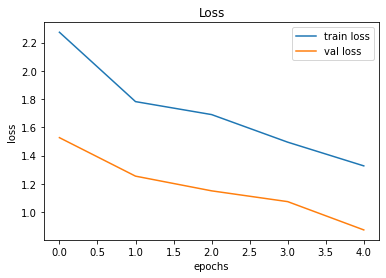

In [40]:
plt.plot(x_list, train_loss_list, label='train loss')
plt.plot(x_list, val_loss_list, label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

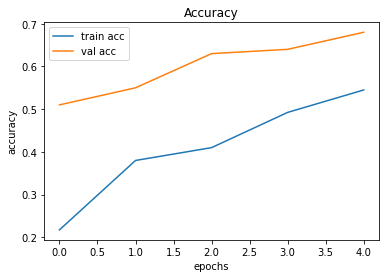

In [41]:
plt.plot(x_list, train_acc_list, label='train acc')
plt.plot(x_list, val_acc_list, label='val acc')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [42]:
k = 7

additional_train_transforms = additional_train_transforms_list[k]


data_transforms = {
'train': transforms.Compose(additional_train_transforms + basic_train_transforms),
'val': transforms.Compose(val_transfrom_list),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print('Training with transforms of ' + transforms_description[k])
print('')

model_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_acc = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = N_epoch)


list_of_train_loss_list.append(train_loss_list)
list_of_train_acc_list.append(train_acc_list)
list_of_val_loss_list.append(val_loss_list)
list_of_val_acc_list.append(val_acc_list)
list_of_best_acc.append(best_acc)

Training with transforms of RandomRotation

Epoch 0/4
----------
train Loss: 2.1285 Acc: 0.2625
val Loss: 1.9921 Acc: 0.2900

Epoch 1/4
----------
train Loss: 1.4902 Acc: 0.4975
val Loss: 1.8163 Acc: 0.4500

Epoch 2/4
----------
train Loss: 1.2407 Acc: 0.5850
val Loss: 1.9164 Acc: 0.3200

Epoch 3/4
----------
train Loss: 1.1848 Acc: 0.6200
val Loss: 1.8396 Acc: 0.3500

Epoch 4/4
----------
train Loss: 0.9722 Acc: 0.6750
val Loss: 1.8039 Acc: 0.3700

Training complete in 1m 45s
Best val Acc: 0.450000


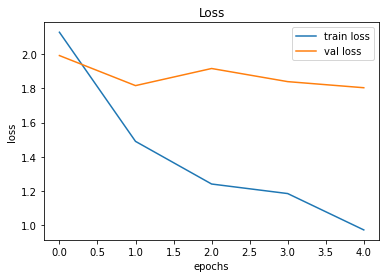

In [43]:
plt.plot(x_list, train_loss_list, label='train loss')
plt.plot(x_list, val_loss_list, label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

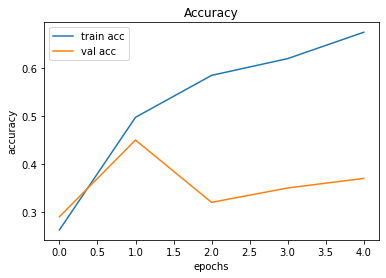

In [44]:
plt.plot(x_list, train_acc_list, label='train acc')
plt.plot(x_list, val_acc_list, label='val acc')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [45]:
k = 8

additional_train_transforms = additional_train_transforms_list[k]


data_transforms = {
'train': transforms.Compose(additional_train_transforms + basic_train_transforms),
'val': transforms.Compose(val_transfrom_list),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print('Training with transforms of ' + transforms_description[k])
print('')

model_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_acc = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = N_epoch)


list_of_train_loss_list.append(train_loss_list)
list_of_train_acc_list.append(train_acc_list)
list_of_val_loss_list.append(val_loss_list)
list_of_val_acc_list.append(val_acc_list)
list_of_best_acc.append(best_acc)

Training with transforms of Resize, CenterCrop, RandomVerticalFlip

Epoch 0/4
----------
train Loss: 2.1448 Acc: 0.2375
val Loss: 1.3228 Acc: 0.5400

Epoch 1/4
----------
train Loss: 1.5615 Acc: 0.4375
val Loss: 1.0062 Acc: 0.6700

Epoch 2/4
----------
train Loss: 1.2970 Acc: 0.5675
val Loss: 0.9737 Acc: 0.6500

Epoch 3/4
----------
train Loss: 1.2331 Acc: 0.5850
val Loss: 0.8386 Acc: 0.6800

Epoch 4/4
----------
train Loss: 1.0604 Acc: 0.6350
val Loss: 0.7602 Acc: 0.7300

Training complete in 4m 36s
Best val Acc: 0.730000


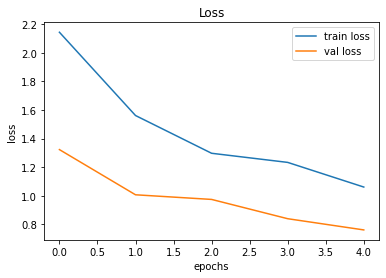

In [46]:
plt.plot(x_list, train_loss_list, label='train loss')
plt.plot(x_list, val_loss_list, label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

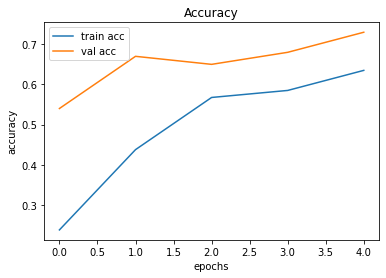

In [47]:
plt.plot(x_list, train_acc_list, label='train acc')
plt.plot(x_list, val_acc_list, label='val acc')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [48]:
k = 9

additional_train_transforms = additional_train_transforms_list[k]


data_transforms = {
'train': transforms.Compose(additional_train_transforms + basic_train_transforms),
'val': transforms.Compose(val_transfrom_list),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print('Training with transforms of ' + transforms_description[k])
print('')

model_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_acc = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = N_epoch)


list_of_train_loss_list.append(train_loss_list)
list_of_train_acc_list.append(train_acc_list)
list_of_val_loss_list.append(val_loss_list)
list_of_val_acc_list.append(val_acc_list)
list_of_best_acc.append(best_acc)

Training with transforms of Resize, CenterCrop, RandomAffine

Epoch 0/4
----------
train Loss: 2.3798 Acc: 0.1650
val Loss: 2.4857 Acc: 0.2000

Epoch 1/4
----------
train Loss: 1.9910 Acc: 0.2875
val Loss: 2.1407 Acc: 0.2400

Epoch 2/4
----------
train Loss: 1.7747 Acc: 0.3850
val Loss: 2.0852 Acc: 0.3400

Epoch 3/4
----------
train Loss: 1.6648 Acc: 0.3800
val Loss: 2.4231 Acc: 0.2400

Epoch 4/4
----------
train Loss: 1.6274 Acc: 0.4325
val Loss: 2.8580 Acc: 0.1900

Training complete in 4m 31s
Best val Acc: 0.340000


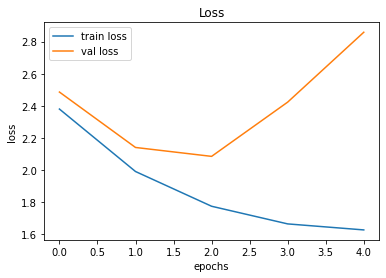

In [49]:
plt.plot(x_list, train_loss_list, label='train loss')
plt.plot(x_list, val_loss_list, label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

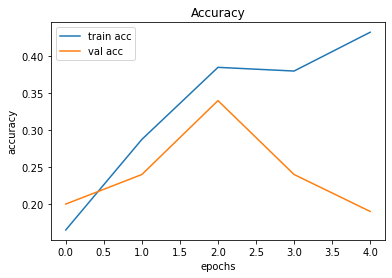

In [50]:
plt.plot(x_list, train_acc_list, label='train acc')
plt.plot(x_list, val_acc_list, label='val acc')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 4. Results

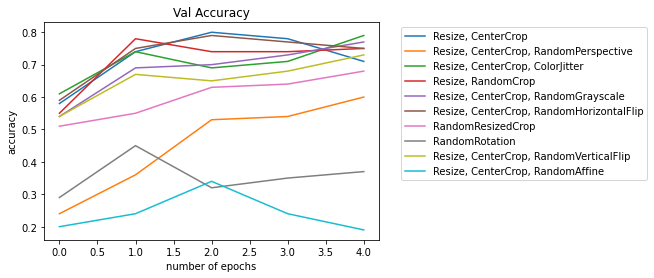

In [51]:
n_transforms = len(transforms_description)

x_coord = list(np.arange(0, n_transforms))

for i in range(n_transforms):
    plt.plot(list_of_val_acc_list[i], label = transforms_description[i] )
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.title('Val Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

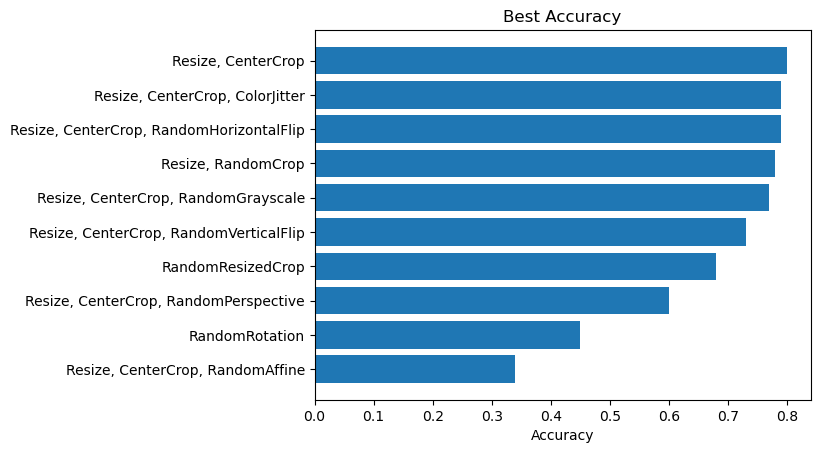

In [52]:
df = pd.DataFrame()
df['best_accuracy'] = list_of_best_acc
df['description'] = transforms_description
d = df.sort_values(by=['best_accuracy'], ascending = False)

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
x = d['best_accuracy']
y = d['description']
y_pos = np.arange(len(y))

ax.barh(y_pos, x)
ax.set_yticks(y_pos, labels=y)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy')
ax.set_title('Best Accuracy')

plt.show()

The results are interesting.  It turns out that the image transforms of 'Resize, CenterCrop' had best val accuracy of 0.8.  

'Random Rotation' and 'Resize, CenterCrop, RandomAffine' were not good at all.  

The graph is quite self-explainatory of the overall results.  

# 5.  Future Improvements and Notes

1.  With limited computing power, only 200 training data and 100 test data are used.  If we have more powerful processor, then we can have more accurate results.  

2.  Also, the number of epochs were 5 due to the crushing problem.  If we have more powerful processor or find a way to prevent the crush, then we will have more accurate results.  

3.  I only tested 10 combinations of Image Transforms.  But one can research further to make more combination of Image Transforms.   It is a trial and error method to see which image transforms works best, but one can attempt to make a combination among the image transforms that worked best.  For instance, take transforms of 'Resize, CenterCrop, Colerjitter, RandomHorizotalFlip' all toghether, and see if the performance gets better. 

4.  For the transforms with randomness, the probability is set to 0.5.  It is not known that if p=0.5 gives the best result.  Different probabilities can be tested for possible improvements of the result. 